In [196]:
#import pretty_midi
import glob
import numpy as np
import gensim
import music21
import sklearn
import random
import json


from matplotlib import pyplot as plt
%matplotlib inline

#from bokeh.plotting import output_file, output_notebook, ColumnDataSource, figure, show
#from bokeh.models import HoverTool

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [197]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

def transpose_to_all(c):
    out = []
    old = c
    for i in range(12):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out

def transpose_to_some(c, degree):
    out = []
    out.append(c)
    old = c
    for i in range(degree):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out
        
def c_to_strep(c):
    rep = ""
    for i in range(12):
        if i in c.pitchClasses:
            rep += "1"
        else:
            rep += "0"
    return rep

def strep_to_c(strep):
    pcs = []
    for i, v in enumerate(strep):
        if v == '1':
            pcs.append(i)
    return music21.chord.Chord(pcs)

def strep_to_symbol(strep):
    c = strep_to_c(strep)
    return music21.harmony.chordSymbolFigureFromChord(c)

In [198]:
ns = {}
tok_counts = {}

for subcorpus in glob.glob('*.json'):
    with open(subcorpus, 'r') as f:
        subc = json.load(f)
        ns[subcorpus] = len(subc)
        tok_counts[subcorpus] = sum([len(d) for d in subc])
        

In [199]:
ns, tok_counts

({'ycac_all.json': 8729, 'ycac_lite.json': 2048},
 {'ycac_all.json': 12275807, 'ycac_lite.json': 2783459})

In [200]:
def generate_embeddings(composer, sample_size=None):
    docs = json.load(open('{}'.format(composer)))
    
    if sample_size is None:
        docs = docs
    else:
        docs = random.sample(docs, sample_size)
    
    chunked_docs = []

    for doc in docs:
        chunked_docs.extend([x for x in chunks(doc, 32)])
        
    sentences = chunked_docs

    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=2, sg=1)
    
    return model

In [201]:
def plot_relations(a, b, composer, sample_size=None,model=None,reduction='pca'):
    
    if model is None:
        model = generate_embeddings(composer, sample_size)
    
    if sample_size is None:
        n = ns[composer]
    else:
        n = sample_size
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
    pca = PCA(n_components=2)
    
    if reduction == 'tsne':
        proj = tsne.fit_transform(embeddings)
    else:
        proj = pca.fit_transform(embeddings)

    all_a = [c_to_strep(x) for x in transpose_to_all(a)]
    all_b = [c_to_strep(x) for x in transpose_to_all(b)]

    pairs = zip(all_a, all_b)
    focus = all_a + all_b
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [list(words).index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]

    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    # labels = [chord2name[l] for l in labels]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]), fontsize=24)
        
    def lookup_strep(strep):
        i = words.index(strep)
        return (proj[i, 0], proj[i, 1])
        
    arrows = [map(lookup_strep, pair) for pair in pairs]

    arrow_params = {'length_includes_head': True,
                    'head_starts_at_zero': True}
    
    #for arrow in arrows:
    #    ax.arrow(arrow[0][0], arrow[0][1], arrow[1][0] - arrow[0][0], arrow[1][1] - arrow[0][1], alpha=0.7, 
    #         linewidth=1, head_width=.1, head_length=.1, **arrow_params)
    
    ax.scatter(x, y, c='black')
        
    ax.set_title('{composer} (no. of docs = {n}) {reduction}'.format(composer=composer.replace('.json', ''), 
                                                                     n=n, reduction=reduction.upper()))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
        
    f.show()

In [33]:
def _plot_one(a, composer, sample_size=None, model=None):
    
    if model is None:
        model = generate_embeddings(composer, sample_size)
        
    if sample_size is None:
        n = ns[composer]
    else:
        n = sample_size
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    # tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=200)
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)
    
    focus = [c_to_strep(x) for x in transpose_to_all(a)] 
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [list(words).index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]

    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]))
    
    ax.scatter(x, y, c='black')
        
    ax.set_title('{composer} (no. of docs = {n}) PCA'.format(composer=composer, n=n))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    f.show()

In [34]:
def _plot_collection(collection, composer, sample_size=None, transpose=False, model=None, colors=None):
    
    if model is None:
        model = generate_embeddings(composer, sample_size)
        
    if sample_size is None:
        n = ns[composer]
    else:
        n = sample_size
    
    words = model.vocab.keys()
    embeddings = np.array([model[w] for w in words])
    
    pca = PCA(n_components=2)
    proj = pca.fit_transform(embeddings)
        
    a = []
    
    if transpose:
        for x in collection:
            a.extend(transpose_to_some(x, degree=2))
    else:
        a = collection
        
        
    focus = [c_to_strep(x) for x in a] 
    
    q_words = [x for x in model.vocab.keys() if x in focus]
    
    q_indices = [list(words).index(x) for x in q_words]
    
    x=proj[q_indices,0]
    y=proj[q_indices,1]
    
    labels = [" ".join(strep_to_c(w).pitchNames) for w in q_words]
    
    f, ax = plt.subplots()

    for lxy in zip(labels, x, y):
        ax.annotate(lxy[0], (lxy[1],lxy[2]))
        
    if colors is None:
        ax.scatter(x, y, c='black')
    else:
        ax.scatter(x, y, c=colors)
        
    ax.set_title('{composer} (no. of docs = {n}) PCA'.format(composer=composer, n=n))

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
    plt.suptitle('lol')
    
    f.show()

In [35]:
neighborhood = [
music21.chord.Chord(['C', 'E', 'G']),
 music21.chord.Chord(['C', 'E', 'G', 'B-']),
]

In [22]:
colors = []
chords = []
palette = ['blue', 'green', 'red', 'yellow', 'orange']

for i in range(5):
    for c in neighborhood:
        chords.append(c.transpose(i*2))
        colors.append(palette[i])
    

In [23]:
w2v = gensim.models.Word2Vec()

#m = w2v.load('ycac.json.model')

In [219]:
%%time
m = generate_embeddings('ycac_lite.json')

CPU times: user 1min 37s, sys: 93.3 ms, total: 1min 37s
Wall time: 49.6 s


In [205]:
m['001000010001']

array([ 0.08465685, -0.04196529,  0.39988726,  0.34226325, -0.19445039,
        0.54734707, -0.4365693 ,  0.20394237, -0.16010168, -0.25968498,
       -0.38678873, -0.35401008,  0.13110436,  0.2900807 , -0.15295446,
        0.03003944,  0.6111443 ,  0.31588358,  0.01311144,  0.11974087,
       -0.39860103, -0.0682092 ,  0.50254351, -0.18535827,  0.16751942,
        0.05043533, -0.06636015, -0.21972547, -0.80566448,  0.39660618,
       -0.35012811,  0.30975553, -0.11539837, -0.16749689, -0.0027549 ,
       -0.32189074, -0.07886986, -0.3849901 ,  0.04796751,  0.44150287,
        0.23132165,  0.15902144, -0.01019602,  0.21099971, -0.24211071,
       -0.31066555,  0.1418931 ,  0.61890823, -0.1212924 , -0.33964637,
        0.43045977, -0.27016693, -0.17773284,  0.04444658, -0.02267519,
        0.35531667,  0.01222497,  0.25192839, -0.11915314, -0.13769607,
        0.27661723, -0.27870482,  0.20596156,  0.16303633, -0.00852308,
       -0.58255625, -0.2485255 ,  0.30720434,  0.0603145 , -0.19

In [206]:
a = music21.chord.Chord(['G', 'B', 'D'])
b = music21.chord.Chord(['C', 'E', 'G'])

In [207]:
A_maj = music21.chord.Chord(['A', 'C#', 'E'])

In [208]:
c_to_strep(A_maj)

'010010000100'

In [112]:
m[c_to_strep(A_maj)]

array([-0.0023022 ,  0.03368771,  0.35472018,  0.19367439, -0.20733193,
       -0.27191722, -0.2032223 , -0.02848213, -0.4911221 , -0.03456428,
       -0.05491349, -0.63491207, -0.01482399,  0.37016803, -0.09307007,
       -0.3463968 ,  0.55330509,  0.13651595,  0.18191825, -0.27308002,
       -0.19235469,  0.46554694, -0.09877716, -0.703444  ,  0.04484038,
        0.22177005, -0.74239308,  0.27348113,  0.01540716,  0.29803953,
        0.23899594,  0.12505792,  0.11858035,  0.18659022,  0.40834963,
       -0.19813246, -0.31247228, -0.09630246,  0.20354398,  0.0194385 ,
        0.13108699,  0.13116187, -0.03297312,  0.21763627, -0.19795255,
       -0.13049705, -0.07823411,  0.11424287,  0.54721349, -0.00087225,
       -0.06702536, -0.02271356,  0.19446678, -0.44566834, -0.5026083 ,
       -0.29703987,  0.26416388, -0.0836942 ,  0.34136286, -0.14767984,
       -0.12637527, -0.3789334 , -0.06148603,  0.0461126 ,  0.13094448,
       -0.03141709,  0.06996732,  0.30858383, -0.247676  ,  0.21

/usr/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


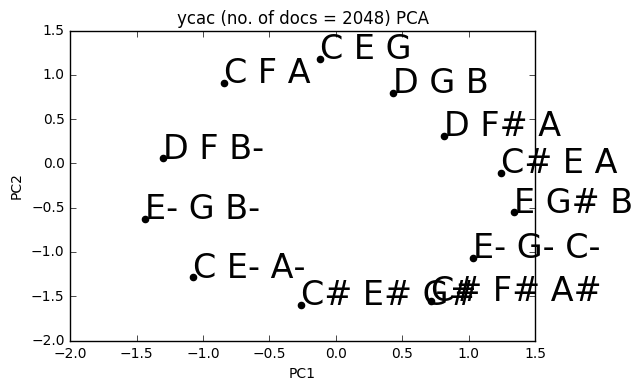

In [41]:
plot_relations(a, b, 'ycac.json', sample_size=None, model=m)

## Output for use in embedding visualizer

In [220]:
embeddings = []
metadata = []

for w in m.vocab:
    embeddings.append(m[w])
    
    stc = strep_to_c(w)
    pns = " ".join(stc.pitchNames)
    root = stc.root().name
    quality = stc.quality
    root_qual = root + " " + quality
    common = stc.commonName
    root_common = root + " " + common
    
    try:
        symb = music21.harmony.chordSymbolFigureFromChord(stc)
    except:
        symb = "*"
        
    pns_ct = len(stc.pitchClasses)
    
    if 'Chord Symbol Cannot Be Identified' in symb:
        symb = "*"
    
    cols = ["\"{}\"".format(w),m.vocab[w].count,symb,root,quality,root_qual,common,root_common,pns,pns_ct]
    metadata.append(cols)

metadata.insert(0, ['canonical', 'count', 'symbol', 'root', 'quality', 'root_qual', 'common', 'root_common', 'pitch_names', 'chord_size'])

In [221]:
A_maj.commonName

'major triad'

In [222]:
len(m.vocab)

1426

In [223]:
len(embeddings), len(metadata)

(1426, 1427)

In [224]:
metadata[:5]

[['canonical',
  'count',
  'symbol',
  'root',
  'quality',
  'root_qual',
  'common',
  'root_common',
  'pitch_names',
  'chord_size'],
 ['"001100001000"',
  594,
  '*',
  'D',
  'other',
  'D other',
  'tritone-fourth',
  'D tritone-fourth',
  'D E- A-',
  3],
 ['"110100011100"',
  20,
  'A-maj7/CaddA,D-',
  'A-',
  'major',
  'A- major',
  'complement of all tri-chord hexachord',
  'A- complement of all tri-chord hexachord',
  'C D- E- G A- A',
  6],
 ['"001010010100"',
  1989,
  '*',
  'E',
  'minor',
  'E minor',
  'quartal tetramirror',
  'E quartal tetramirror',
  'D E G A',
  4],
 ['"100010011100"',
  16,
  'A-+M7/CaddA',
  'A-',
  'augmented',
  'A- augmented',
  'center-cluster pentamirror',
  'A- center-cluster pentamirror',
  'C E G A- A',
  5]]

In [225]:
assert len(embeddings) == len(metadata) - 1

In [226]:
emb_as_np = np.array(embeddings)

In [230]:
np.savetxt('embeddings_lite.tsv', emb_as_np, fmt='%.6f', delimiter='\t')
np.save('embeddings_lite.np',emb_as_np)

In [232]:
json.dump(metadata,open('metadata_lite.json', 'w'))

In [228]:
with open('metadata_lite.tsv', 'w') as f:
    for line in metadata:
        f.write("\t".join([str(i) for i in line]) + "\n")

### Sanity checking

cf. 
https://raw.githubusercontent.com/eamonnbell/music-mining/master/gensim/embeddings.tsv

https://raw.githubusercontent.com/eamonnbell/music-mining/master/gensim/metadata.tsv


In [101]:
m['001100001000']

array([-0.46670029, -0.15171346,  0.14998756, -0.02884695, -0.37854949,
       -0.48653343, -0.60088253,  0.39617902,  0.37917057, -0.62501222,
        0.46386194, -0.50189549, -0.0783459 , -0.3586379 ,  0.21515633,
       -0.77489614, -0.18783224,  0.07080229,  0.70053947,  0.21606967,
       -0.40307519, -0.08044077,  0.19673419,  0.37965095, -0.30855235,
       -0.19562443, -0.29290694,  0.08061913,  0.54328132, -0.32161224,
        0.61760527,  0.07465228,  0.15741244,  0.18900725, -0.18688534,
       -0.28078055, -0.43853244,  0.37208191,  0.24916093,  0.22112487,
       -0.27407679,  0.50982428,  0.74012673, -0.31914672,  0.14622957,
       -0.34878227, -0.07927928,  0.11169559,  0.38234913,  0.44806105,
       -0.67801833, -0.68340546, -0.30128863,  0.20632121,  0.13692881,
        0.15105192,  0.82171643, -0.24892622,  0.00181473,  0.5772115 ,
        0.24198714, -0.17258847,  0.24456295, -0.04545319,  0.32085422,
       -0.18216383,  0.20580791,  0.08907092, -0.25203475, -0.02

In [103]:
metadata[1]

['001100001000', 594, '*', 'D E- A-', 7]

# Other junk

In [18]:
pca_neighbors = []

for strep, dist in result:
    pca_neighbors.append(strep_to_c(strep))

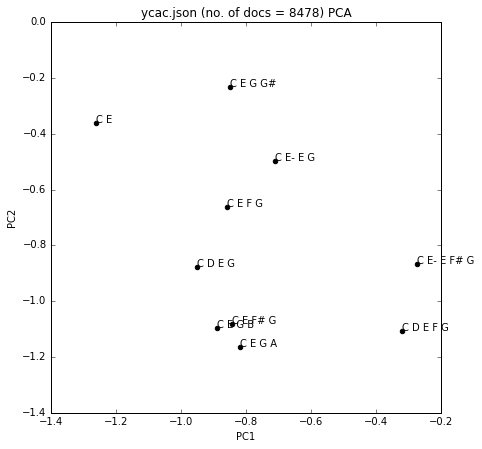

In [20]:
plot_collection(pca_neighbors, 'ycac.json', model=m)

In [21]:
model_names = [
    '1700_to_1749.json',
    '1750_to_1799.json',                
    '1800_to_1849.json',
    '1850_to_1899.json',
    'ycac.json'
              ]

def gen_all():
    for model_name in model_names:
        m = generate_embeddings(model_name)
        m.save('{}.model'.format(model_name))
        print('{} trained and saved'.format(model_name))

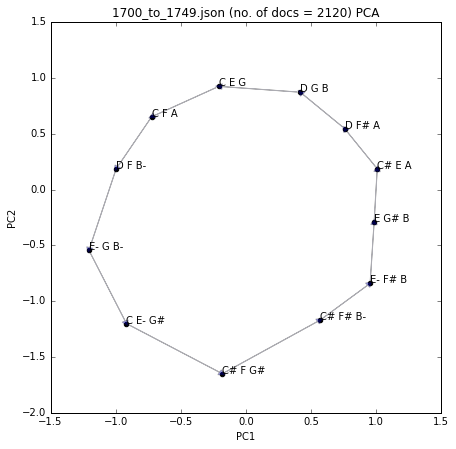

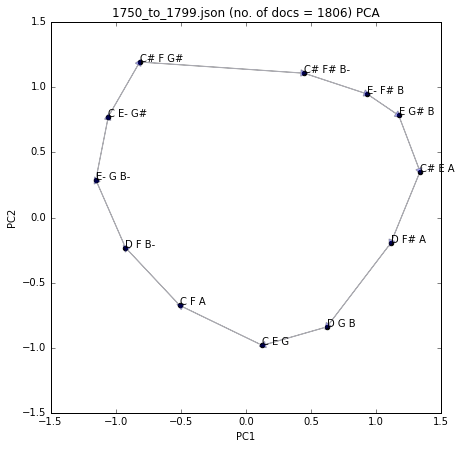

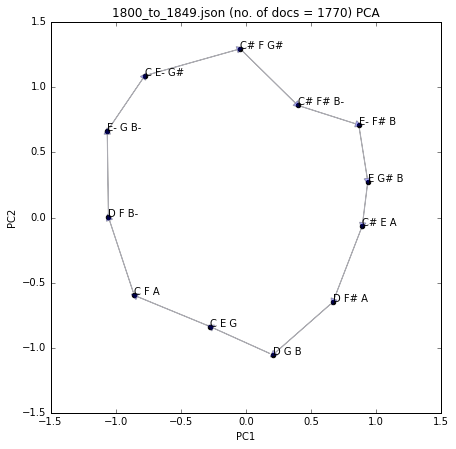

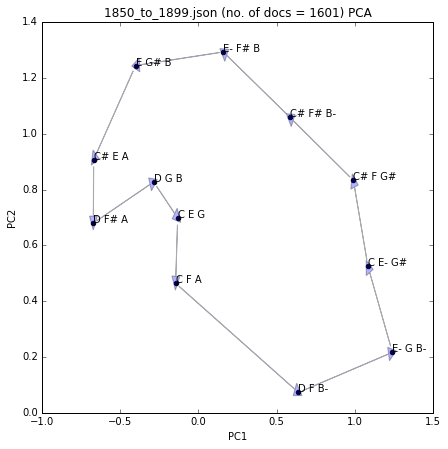

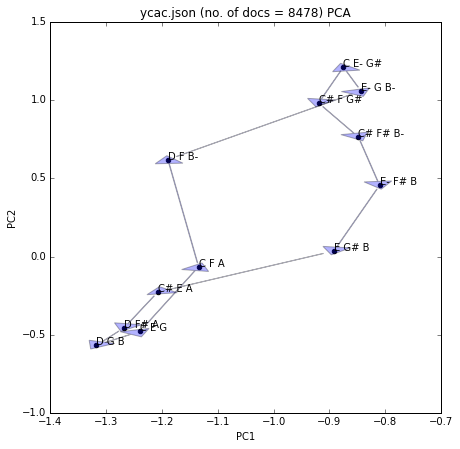

In [25]:
for model_name in model_names:
    w2v = gensim.models.Word2Vec()
    m = w2v.load('{}.model'.format(model_name))
    plot_relations(a, b, '{}'.format(model_name), sample_size=None, model=m)

In [11]:
doit = lambda x: plot_relations(a, b, '{}'.format(x), sample_size=None, model=generate_embeddings(x), reduction='pca')

In [45]:
eras = """1650_to_1699.json
1700_to_1749.json
1750_to_1799.json
1800_to_1849.json
1850_to_1899.json
1900_to_1950.json""".split('\n')

composers = """Bach.json
Beethoven.json
Brahms.json
Chopin.json
Dvorak.json
Handel.json
Haydn.json
Hummel.json
Liszt.json
Mendelssohn.json
Mozart.json
Saint-Saens.json
Scarlatti.json
Schubert.json
Schumann.json
Tchaikovsky.json
Telemann.json
Verdi.json
Vivaldi.json
Wagner.json""".split('\n')

weird = """Wagner.json
Schumann.json
Saint-Saens.json""".split('\n')

todo = """Handel.json
Haydn.json
Beethoven.json
Schumann.json""".split('\n')

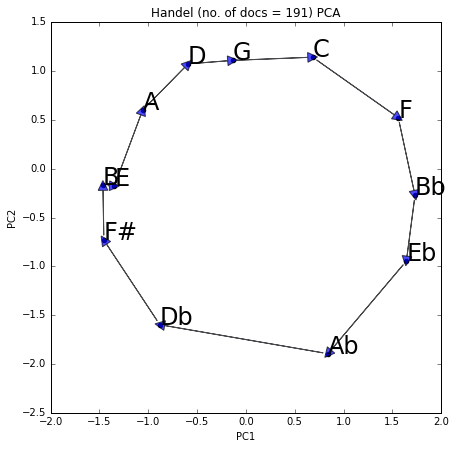

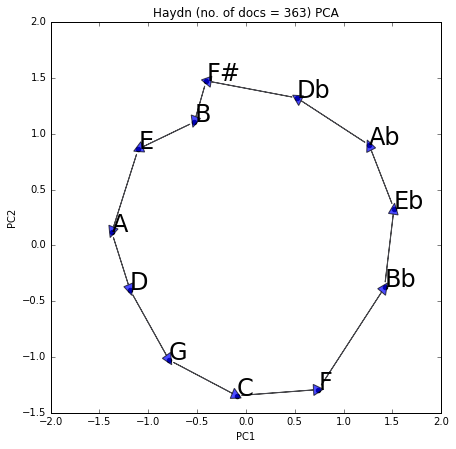

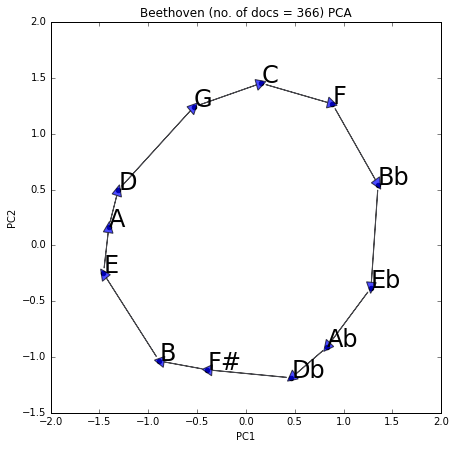

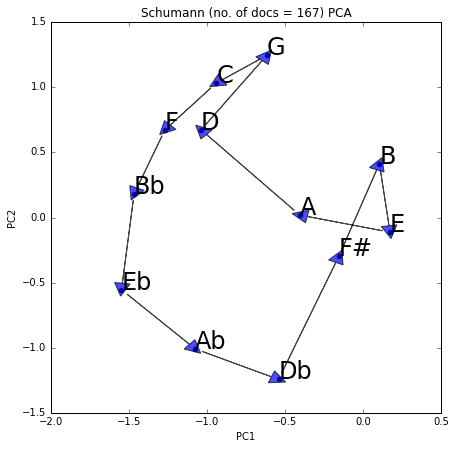

In [46]:
for composer in todo:
    doit(composer)

In [40]:
chords = ['E- F# B', 'C# F G#', 'C F A', 'C# F# B-', 'C E G', 'D F B-', 'D G B', 'E- G B-', 'D F# A', 'E G# B', 'C# E A', 'C E- G#']
names = ['B', 'Db', 'F', 'F#', 'C', 'Bb', 'G', 'Eb', 'D', 'E', 'A', 'Ab']

In [41]:
chord2name = dict(zip(chords, names))